# Calibrating the LDM: Mackenzie Smith

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.cm import ScalarMappable

### 1.) Consider experimental nuclear masses
The AME data was loaded into a Pandas dataframe.

In [4]:
## read in the AME Data ##

column_names = ['N','Z','BE/A']
df = pd.read_csv('AME2020_BEperNucleon', delimiter=' ', names=column_names, header=None)
print(df)

        N    Z      BE/A
0       8    8  7.976207
1       9    8  7.750729
2      10    8  7.767098
3      11    8  7.566495
4      12    8  7.568571
...   ...  ...       ...
2461  157  108  7.296247
2462  158  108  7.298261
2463  157  109  7.270760
2464  159  110  7.250155
2465  160  110  7.253763

[2466 rows x 3 columns]


In [3]:
## this cell is used for trying to tag certain elements ##

tin_df = df[df['Z'] == 50]
#print(tin_df)
df132 = df[df['Z'] + df['N'] == 132]
##print(df132)

### 2.) Take LDM mass expression

$$
B = a_{vol}A - a_{surf}A^{2/3} - a_{sym}\frac{(N-Z)^2}{A} - a_{c}\frac{Z^2}{A^{1/3}}-\delta (A)
$$

In [6]:
def LDM(N,Z,params):
    A = N + Z
    volterm = params[0]*A
    surfterm = params[1]*A**(2./3.)
    symterm = params[2]*((N-Z)**2)/A
    coulterm = params[3]*((Z**2)/(A)**(1./3.))
    if N%2 == 0 & Z%2 == 0:
        pairterm = 0.
    elif A%2 == 1:
        pairterm = params[4]/(A**(1./2.))
    else:
        pairterm = 2*params[4]/(A**(1./2.))
    Sum = volterm - surfterm - symterm - coulterm + pairterm
    return Sum

def chisquared(params):
    num = len(df)
    Chi2 = 0.0
    for i in range(0,num):
        line = df.iloc[i]
        n = int(line['N'])
        z = int(line['Z'])
        a = n + z
        be = float(line['BE/A'])*a
        calc = LDM(n,z,params)
        diff = be - calc
        Chi2 = Chi2 + diff**2
    return Chi2

def LDM2(N,Z,params):
    A = N + Z
    volterm = params[0]*A
    surfterm = params[1]*A**(2./3.)
    symterm = params[2]*((N-Z)**2)/A
    coulterm = params[3]*((Z**2)/(A)**(1./3.))
    if N%2 == 0 & Z%2 == 0:
        pairterm = 0.
    elif A%2 == 1:
        pairterm = params[4]/(A**(1./2.))
    else:
        pairterm = 2*params[4]/(A**(1./2.))
    Sum = volterm - surfterm - symterm - coulterm + pairterm
    return Sum/A

def chisquared2(params):
    num = len(df)
    Chi2 = 0.0
    for i in range(0,num):
        line = df.iloc[i]
        n = int(line['N'])
        z = int(line['Z'])
        a = n + z
        be = float(line['BE/A'])
        calc = LDM2(n,z,params)
        diff = be - calc
        Chi2 = Chi2 + diff**2
    return Chi2

### 3.) Use chi-square approach to determine LDM parameters

Below, I have an initial guess of the parameters based on the lecture slides. I then pass this initial guess to the scipy.optimize.minimize function with the BFGS optimization algorithm.


In [7]:
print("")
init_params = [15.68,18.56,28.1,0.717,0.]
print("Initial parameters are:")
print("")
print(init_params)
print("")

res = minimize(chisquared,init_params,method='BFGS')#bounds=bnds,method='BFGS')


Initial parameters are:

[15.68, 18.56, 28.1, 0.717, 0.0]



After running the minimize function, below are the calibrated parameters I get:

In [8]:
print("")
print("volume term is " + str(res.x[0]))
print("surface term is " + str(res.x[1]))
print("symmetry term is " + str(res.x[2]))
print("coulomb term is " + str(res.x[3]))
print("pairing term is " + str(res.x[4]))


volume term is 15.42548882699324
surface term is 16.518150968015366
symmetry term is 22.791440036923447
coulomb term is 0.6967705391048544
pairing term is -9.358236330848104


Once we have our calibrated model, we can compare it with the data. Below is a graph showing the AME2020 data superimposed with the model based on the initial guess (blue) and the calibrated model (red). We can see it fits fairly well, but clearly not perfect.

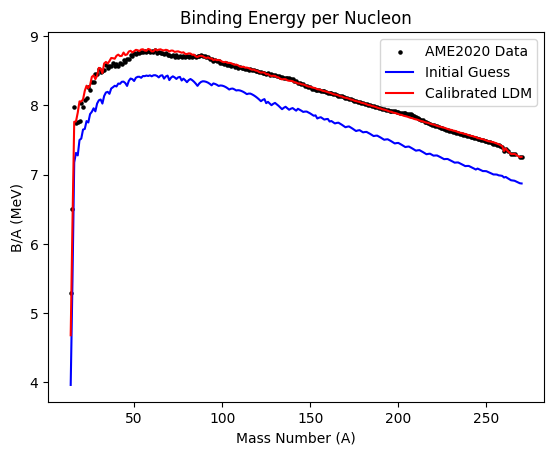

In [10]:
df['A'] = df['Z'] + df['N']
#print(df)
unique_a = df['A'].unique()
#print(unique_a)
unique_a_array = np.array([])
max_be = np.array([])
for unique_val in unique_a:
    filtered_df = df[df['A'] == unique_val]
    max_col_row = filtered_df.loc[filtered_df['BE/A'].idxmax()]
    unique_a_array = np.append(unique_a_array,unique_val)
    max_be = np.append(max_be,max_col_row['BE/A'])

newParams = res.x

new_df = df[(df['A'].isin(unique_a_array)) & (df['BE/A'].isin(max_be))]
new_df = new_df.sort_values(by='A')

a_val = []
be_val1 = []
be_val2 = []
for i in range(0,len(new_df)):
    n = int(new_df.iloc[i]['N'])
    z = int(new_df.iloc[i]['Z'])
    a = n + z
    a_val.append(new_df.iloc[i]['A'])
    be_val1.append(LDM2(n,z,init_params))
    be_val2.append(LDM2(n,z,newParams))

print("")
plt.figure(1)
plt.title("Binding Energy per Nucleon")
plt.ylabel("B/A (MeV)")
plt.xlabel("Mass Number (A)")
plt.scatter(unique_a_array,max_be,color='black',marker='o',s=5,label="AME2020 Data")
plt.plot(a_val,be_val1,'b',label="Initial Guess")
plt.plot(a_val,be_val2,'r',label="Calibrated LDM")
plt.legend()

To investigate the discrepancies from the model, I have plotted the residuals of each data point from the model in three manners. 1) In the form of the chart of the nuclides, where we can see an almost staircase-like pattern emerging. Note, as the model does not work as well for lower mass nuclei, if we exclude the lightest and most exotic nuclei, this pattern emerges even clearer. The other two forms are residuals vs 2) proton number and 3) neutron number. In these last two depictions of the residuals, the peaks are consistent at numbers 28, 50, and 82, whereas the neutron plot includes a peak near 126!

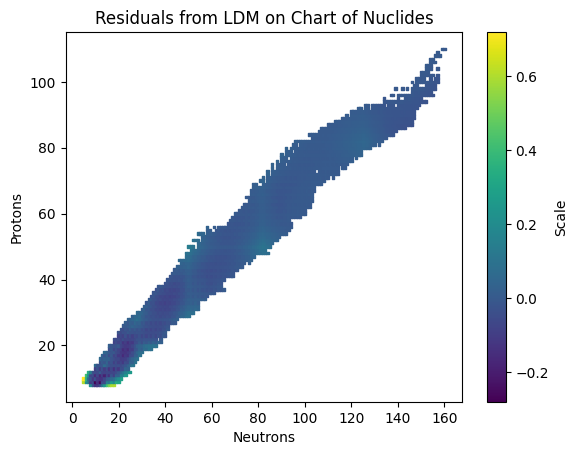

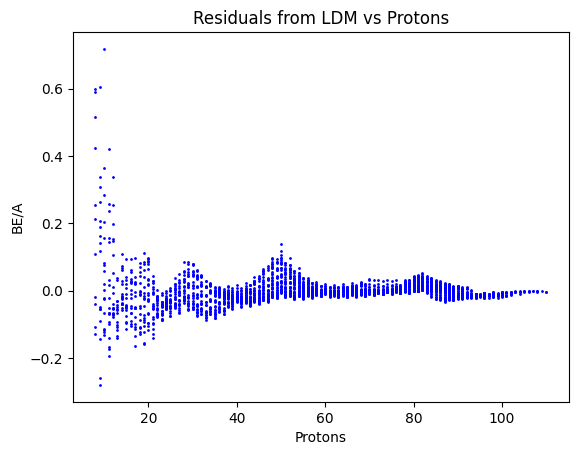

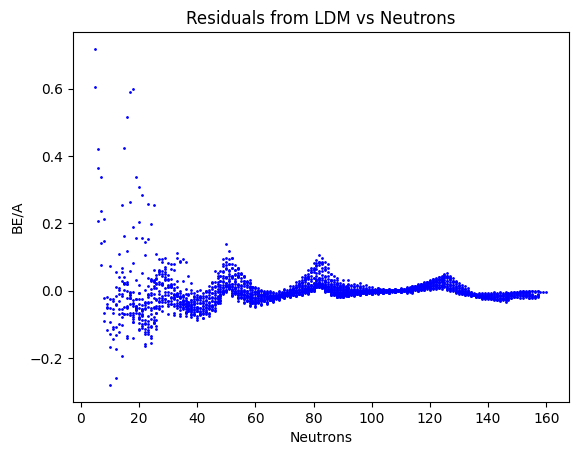

In [11]:
## this cell will create a new column to keep track of residuals ##

print("")
resid = []
Narr = []
Zarr = []
for i in range(0,len(df)):
    line = df.iloc[i]
    n = int(line['N'])
    z = int(line['Z'])
    bea = float(line['BE/A'])
    becalc = LDM(n,z,res.x)/(n+z)
    resid.append((bea-becalc))
    Narr.append(n)
    Zarr.append(z)
df['resid'] = resid

plt.figure(2)
plt.scatter(Narr,Zarr,c=resid,marker='s',cmap='viridis',s=3)
plt.xlabel("Neutrons")
plt.ylabel("Protons")
plt.title("Residuals from LDM on Chart of Nuclides")
plt.colorbar(label="Scale")

plt.figure(3)
plt.title("Residuals from LDM vs Protons")
plt.xlabel("Protons")
plt.ylabel("BE/A")
plt.plot(Zarr,df['resid'],'b.',markersize=2)

plt.figure(4)
plt.title("Residuals from LDM vs Neutrons")
plt.xlabel("Neutrons")
plt.ylabel("BE/A")
plt.plot(Narr,df['resid'],'b.',markersize=2)

### 4.) Compute the Hessian and covariance matrices



To compute the Hessian, we must compute the second partial derivatives of the $\chi^{2}$ function with respect to each of the five input parameters. Thus, we construct a 5x5 matrix where each element is the summation across each data point. Conveniently, the BFGS method in scipy.optimize.minimize computes an inverse Hessian that we can take the inverse of to find our Hessian. Below is the printed Hessian from the optimization method.

In [12]:
print("")
print("Hessian from BFGS:")
print("")
print(np.linalg.inv(res.hess_inv))


Hessian from BFGS:

[[ 1.11421724e+08 -2.00079549e+07 -3.66842218e+06 -6.04064819e+08
   4.05078268e+04]
 [-2.00079549e+07  3.64235583e+06  6.46328895e+05  1.06746824e+08
  -7.98177037e+03]
 [-3.66842218e+06  6.46328895e+05  1.47897783e+05  1.95707742e+07
  -1.21200502e+03]
 [-6.04064819e+08  1.06746824e+08  1.95707742e+07  3.36579275e+09
  -1.96456712e+05]
 [ 4.05078268e+04 -7.98177037e+03 -1.21200502e+03 -1.96456712e+05
   6.22800347e+01]]


However, in the spirit of pursuing knowledge, I analytically computed the Hessian with the expression for our $\chi^{2}$ and it is printed below. The Hessian's match up very well with the exception of the elements relating to our pairing term parameter. However, the discrepancy is consistent across some constant value, so at least it's consistent.

In [13]:
scipyhess = np.linalg.inv(res.hess_inv)
Hess = np.zeros((5,5))
for i in range(0,len(df)):
    line = df.iloc[i]
    n = int(line['N'])
    z = int(line['Z'])
    a = n + z
    if n%2 == 0 and z%2 == 0:
        pair=0.
    elif a%2 == 0:
        pair = -2./np.sqrt(a)
    else:
        pair = -1./np.sqrt(a)
    Hess[0,0] = Hess[0,0] + a**2
    Hess[0,1] = Hess[0,1] - a**(5./3)
    Hess[1,1] = Hess[1,1] + a**(4./3)
    Hess[2,2] = Hess[2,2] + (n-z)**(4)/a**2
    Hess[3,3] = Hess[3,3] + z**4/a**(2/3)
    Hess[4,4] = Hess[4,4] + pair**2
    Hess[0,2] = Hess[0,2] - (n-z)**2
    Hess[0,3] = Hess[0,3] - (z**2)*a**(2/3)
    Hess[0,4] = Hess[0,4] - pair*a
    Hess[1,2] = Hess[1,2] + (n-z)**2/a**(1/3)
    Hess[1,3] = Hess[1,3] + z**2*a**(1/3)
    Hess[1,4] = Hess[1,4] + pair*a**(2/3)
    Hess[2,3] = Hess[2,3] + z**2*(n-z)**2/a**(4/3)
    Hess[2,4] = Hess[2,4] + pair*(n-z)**2/a
    Hess[3,4] = Hess[3,4] + pair*z**2/a**(1/3)
Hess[1,0] = Hess[0,1]
Hess[2,0] = Hess[0,2]
Hess[2,1] = Hess[1,2]
Hess[3,0] = Hess[0,3]
Hess[3,1] = Hess[1,3]
Hess[3,2] = Hess[2,3]
Hess[4,0] = Hess[0,4]
Hess[4,1] = Hess[1,4]
Hess[4,2] = Hess[2,4]
Hess[4,3] = Hess[3,4]

Hess = 2*Hess
print("")
print("Below is my computed Hessian:")
print("")
print(Hess)
print("")


Below is my computed Hessian:

[[ 1.11421718e+08 -2.00079539e+07 -3.66842200e+06 -6.04064787e+08
   5.44642209e+04]
 [-2.00079539e+07  3.64235566e+06  6.46328862e+05  1.06746818e+08
  -1.07288678e+04]
 [-3.66842200e+06  6.46328862e+05  1.47897781e+05  1.95707732e+07
  -1.62914087e+03]
 [-6.04064787e+08  1.06746818e+08  1.95707732e+07  3.36579258e+09
  -2.64317203e+05]
 [ 5.44642209e+04 -1.07288678e+04 -1.62914087e+03 -2.64317203e+05
   7.51045652e+01]]



Next, we can find the covariance matrix by multiplying our inverse Hessian with a scale factor, s, designed to normalize the $\chi^{2}$ function to the number of data points present minus number of parameters.

In [14]:
chiinit = chisquared(init_params)
Nd = len(df)
Np = len(init_params)
s = (chiinit)/(Nd-Np)
print("The chi-squared of our initial parameters:")
print(chiinit)
print("")
print("")
print("S-factor (not the astrophysical one...):")
print(s)

cov_mat = s*res.hess_inv
print("")
print("Covariance matrix:")
print("")
print(cov_mat)

The chi-squared of our initial parameters:
8899772.452384973


S-factor (not the astrophysical one...):
3616.323629575365

Covariance matrix:

[[1.07140287e-01 3.36495907e-01 2.38955912e-01 7.21711794e-03
  8.55489085e-01]
 [3.36495907e-01 1.07685408e+00 7.36809979e-01 2.21506054e-02
  3.35800317e+00]
 [2.38955912e-01 7.36809979e-01 6.48637212e-01 1.58392990e-02
  1.59523854e+00]
 [7.21711794e-03 2.21506054e-02 1.58392990e-02 5.04280101e-04
  4.36384329e-02]
 [8.55489085e-01 3.35800317e+00 1.59523854e+00 4.36384329e-02
  1.00700495e+02]]


### 5.) Compute the matrix of correlations between LDM parameters

From here, we have the variance of each parameter with itself and with other variables. Thus, we can find the correlations between each variable to provide additional insight into the model parameters. As shown below, the correlation between each variable is quite strong with the exception of the pairing term.

In [15]:
corr_mat = np.zeros((5,5))

for i in range(0,5):
    for j in range(0,5):
        corr_mat[i,j] = cov_mat[i,j]/(np.sqrt(cov_mat[i,i])*np.sqrt(cov_mat[j,j]))

print("Correlation matrix:")
print("")
print(corr_mat)
print("")

Correlation matrix:

[[1.         0.99066075 0.90644289 0.98186433 0.26044874]
 [0.99066075 1.         0.88160925 0.95054188 0.32246818]
 [0.90644289 0.88160925 1.         0.87578825 0.19738262]
 [0.98186433 0.95054188 0.87578825 1.         0.19364997]
 [0.26044874 0.32246818 0.19738262 0.19364997 1.        ]]



### 6.) What is the effective number of LDM parameters?

To do this, we first scale the Hessian to a conditioned Hessian, which essentially follows the same process as going from covariance to correlation. From here, we can perform a singular value decomposition on the conditioned Hessian and get the eigenvalues associated with each parameter. From here, I then normalize the eigenvalues to where the sum equals 1. We can then see that the first term, the volume parameter, dominates over the other variables. If we define our number of effective parameters to be those whose eigenvalues add to (N-1)/N, where N is the number of parameters, then we can see that there is only one effective parameter!

In [16]:
cond_hess = np.zeros((5,5))

for i in range(0,5):
    for j in range(0,5):
        cond_hess[i,j] = Hess[i,j]/(np.sqrt(Hess[i,i])*np.sqrt(Hess[j,j]))

SVD = np.linalg.svd(cond_hess)
weight = sum(SVD[1])
print("Eigenvalues:")
print("")
print(SVD[1]/weight)

Eigenvalues:

[8.40822389e-01 1.23874227e-01 3.04573288e-02 4.80849493e-03
 3.75601728e-05]


### 7.) Will the result be the same if the model is calibrated to the binding energy per nucleon?

Yes and no. The fit parameters will give a similar result, but the Hessian, covariance, and correlation matrices are not the same. In this case, the Hessian is divided by a factor of A$^2$, so it is considerably smaller. Additionally, this model will allow the deviation in the higher mass region to not affect the fit as much since binding energy increases with A. The biggest difference I notice here, is how the variables correlate differently and the fact that there are now two parameters with dominating eigenvalues. In this case, it is both the volume term and the surface term that are required to achieve the confidence condition defined in part 6. Thus, there are now two effective parameters for this model.

In [17]:
res2 = minimize(chisquared2,init_params,method='BFGS')#bounds=bnds,method='BFGS')

In [18]:
print("")
print("The LDM parameters using BE/A:")
print("")
print("volume term is " + str(res2.x[0]))
print("surface term is " + str(res2.x[1]))
print("symmetry term is " + str(res2.x[2]))
print("coulomb term is " + str(res2.x[3]))
print("pairing term is " + str(res2.x[4]))

scipyhess2 = np.linalg.inv(res2.hess_inv)
Hess2 = np.zeros((5,5))
for i in range(0,len(df)):
    line = df.iloc[i]
    n = int(line['N'])
    z = int(line['Z'])
    a = n + z
    if n%2 == 0 and z%2 == 0:
        pair=0.
    elif a%2 == 0:
        pair = -2./np.sqrt(a**3)
    else:
        pair = -1./np.sqrt(a**3)
    Hess2[0,0] = Hess2[0,0] + 1
    Hess2[0,1] = Hess2[0,1] - a**(-1./3)
    Hess2[1,1] = Hess2[1,1] + a**(-2./3)
    Hess2[2,2] = Hess2[2,2] + (n-z)**(4)/a**4
    Hess2[3,3] = Hess2[3,3] + z**4/a**(8/3)
    Hess2[4,4] = Hess2[4,4] + pair**2
    Hess2[0,2] = Hess2[0,2] - (n-z)**2/a**2
    Hess2[0,3] = Hess2[0,3] - (z**2)*a**(-4/3)
    Hess2[0,4] = Hess2[0,4] - pair
    Hess2[1,2] = Hess2[1,2] + (n-z)**2/a**(7/3)
    Hess2[1,3] = Hess2[1,3] + z**2*a**(-5/3)
    Hess2[1,4] = Hess2[1,4] + pair*a**(-1/3)
    Hess2[2,3] = Hess2[2,3] + z**2*(n-z)**2/a**(10/3)
    Hess2[2,4] = Hess2[2,4] + pair*(n-z)**2/a**2
    Hess2[3,4] = Hess2[3,4] + pair*z**2/a**(-5/3)
Hess2[1,0] = Hess2[0,1]
Hess2[2,0] = Hess2[0,2]
Hess2[2,1] = Hess2[1,2]
Hess2[3,0] = Hess2[0,3]
Hess2[3,1] = Hess2[1,3]
Hess2[3,2] = Hess2[2,3]
Hess2[4,0] = Hess2[0,4]
Hess2[4,1] = Hess2[1,4]
Hess2[4,2] = Hess2[2,4]
Hess2[4,3] = Hess2[3,4]

Hess2 = 2*Hess2
print("")
print("")
print("Hessian is below:")
print("")
print(Hess2)

chiinit2 = chisquared2(init_params)
Nd = len(df)
Np = len(init_params)
s2 = (chiinit2)/(Nd-Np)
cov_mat2 = s2*res2.hess_inv
print("")
print("")
print("Covariance matrix is below:")
print("")
print(cov_mat2)
corr_mat2 = np.zeros((5,5))

for i in range(0,5):
    for j in range(0,5):
        corr_mat2[i,j] = cov_mat2[i,j]/(np.sqrt(cov_mat2[i,i])*np.sqrt(cov_mat2[j,j]))

print("")
print("")
print("Correlation matrix is below:")
print("")
print(corr_mat2)

cond_hess2 = np.zeros((5,5))

for i in range(0,5):
    for j in range(0,5):
        cond_hess2[i,j] = Hess2[i,j]/(np.sqrt(Hess2[i,i])*np.sqrt(Hess2[j,j]))

SVD2 = np.linalg.svd(cond_hess2)
weight2 = sum(SVD2[1])
print("")
print("")
print("Eigenvalues:")
print("")
print(SVD2[1]/weight2)


The LDM parameters using BE/A:

volume term is 15.017569422309727
surface term is 15.573721040483786
symmetry term is 21.06058222471098
coulomb term is 0.6619903694384586
pairing term is -7.782790383245037


Hessian is below:

[[ 4.93200000e+03 -1.02523511e+03 -1.42603138e+02 -2.25160602e+04
   6.26103560e+00]
 [-1.02523511e+03  2.23465270e+02  2.90796167e+01  4.41717470e+03
  -1.68758792e+00]
 [-1.42603138e+02  2.90796167e+01  6.10338786e+00  6.25058668e+02
  -1.77063149e-01]
 [-2.25160602e+04  4.41717470e+03  6.25058668e+02  1.11716109e+05
  -4.34468630e+07]
 [ 6.26103560e+00 -1.68758792e+00 -1.77063149e-01 -4.34468630e+07
   3.92803007e-02]]


Covariance matrix is below:

[[1.76728059e-02 4.76183672e-02 3.54969030e-02 1.49951140e-03
  1.42211515e-01]
 [4.76183672e-02 1.34430691e-01 8.76796016e-02 3.85881988e-03
  5.03722788e-01]
 [3.54969030e-02 8.76796016e-02 1.54068391e-01 2.85831525e-03
  2.45557293e-01]
 [1.49951140e-03 3.85881988e-03 2.85831525e-03 1.36450876e-04
  8.65712157e